In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ExpSineSquared, RationalQuadratic, DotProduct

plt.rcParams['font.size'] = 14

In [207]:
# Read in data file
df = pd.read_csv('runup_data.csv',parse_dates=True,index_col=0).dropna()
df.drop(columns = ['Tp','slope'],inplace=True) # Hs
# df.drop(columns = ['Hs','slope'],inplace=True) # Tp
# df.drop(columns = ['Hs','Tp'],inplace=True) # Slope
df.head()

,Hs,runup
time,,
2014-05-20 10:00:00,0.538424,0.819012
2014-05-20 13:00:00,0.687159,0.882722
2014-05-20 14:00:00,0.655254,0.885877
2014-05-20 15:00:00,0.526552,0.854396
2014-05-20 16:00:00,0.543070,0.845645


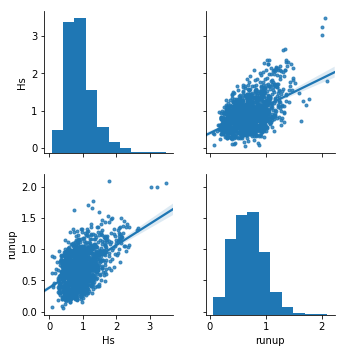

In [208]:
# Data exploration
# Change this two a 2d surface plot on the tril
sns.pairplot(df.sample(round(len(df)/6)),markers='.',kind='reg',size=2.5)

In [209]:
# Split data into training/testing
X = df.drop(columns='runup')
y = df[['runup']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.95, random_state=123)

In [210]:
# Scale training data and then test data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [211]:
# Different Kernel Specification
# Hs/Tp/Slope: (alpha = 0.3)
kernel = Matern(0.1, (1e-2, 1), 1.5)
# kernel = RBF(0.1, (1e-5, 1e-1))

# kernel = RBF(0.1, (1e-5, 1e-1))
# kernel = Matern(0.1, (1e-1, 1), 1.5)
# kernel = DotProduct(0.1, (1e-5, 1e2))
# kernel = ExpSineSquared()
# kenrel = RationalQuadratic()

In [212]:
# Train GP model
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.3, normalize_y=True, random_state=123)
gp.fit(X_train_scaled, y_train)
y_pred, sigma = gp.predict(X_test_scaled, return_std=True)

In [213]:
# Evaluate Predictions
print('RMSE =', np.sqrt(mean_squared_error(y_test,y_pred)))

RMSE = 0.25783053997245386


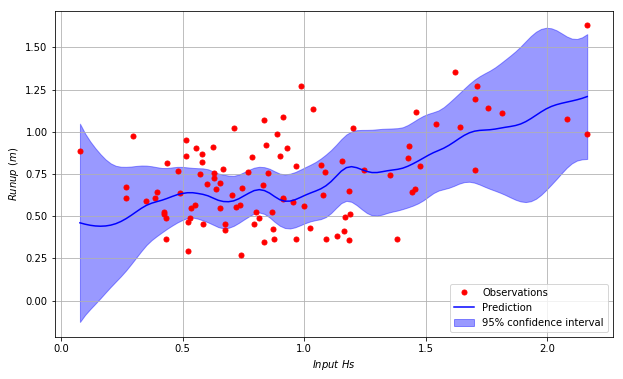

In [223]:
x_actual = X_test_scaled[0:1000:10]
y_actual = y_test.iloc[0:1000:10]
x_predict = np.linspace(x_actual.min(),x_actual.max(),100)
y_predict, predict_sigma = gp.predict(x_predict.reshape(-1, 1),return_std=True)

fig, axes = plt.subplots(figsize=(10,6))
axes.plot(scaler.inverse_transform(x_actual),y_actual,'r.',markersize=10,label='Observations')
axes.plot(scaler.inverse_transform(x_predict), y_predict, 'b-', label='Prediction')
axes.fill_between(scaler.inverse_transform(x_predict),y_predict.ravel() - 1.9600 * predict_sigma,y_predict.ravel() + 1.9600 * predict_sigma,
                 alpha=0.4, color='b', edgecolor='k', label='95% confidence interval')
axes.set_xlabel('$Input$ ' + '$' + X_test.columns[0] + '$')
axes.set_ylabel('$Runup$ $(m)$')
axes.legend(loc='lower right')
axes.grid(True)